# Форекс Сигнал Таамаглах Hidden Markov Model

## 5 Ангилалын Машин Сургалтын Систем

Энэ notebook нь форекс хослолуудын хөдөлгөөнийг дараах 5 ангилалд хуваан таамаглах HMM модель сургана:

1. **High volatility up** - Өндөр хэлбэлзэлтэй өсөлт
2. **Medium volatility up** - Дунд хэлбэлзэлтэй өсөлт
3. **No trend** - Чиглэлгүй (хажуу тийш)
4. **Medium volatility down** - Дунд хэлбэлзэлтэй бууралт
5. **High volatility down** - Өндөр хэлбэлзэлтэй бууралт

### Аргачлал:

- **Walking Forward Analysis**: Модель дараалсан цонхоор сургагдаж, ирээдүйг таамаглана
- **Backtest**: Test датан дээр таамаглалыг шалгана
- **Performance Metrics**: Нийт нарийвчлал болон ангилал тус бүрийн гүйцэтгэлийг хэмжинэ


In [1]:
# Шаардлагатай сангуудыг импортлох
import pandas as pd
import numpy as np
from hmmlearn import hmm
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

warnings.filterwarnings('ignore')

print("Сангууд амжилттай импортлогдлоо ✓")

Сангууд амжилттай импортлогдлоо ✓


## 1. Датаг уншиж боловсруулах функцууд


In [2]:
def load_forex_data(file_path):
    """
    Форекс датаг уншиж, цаг хугацааг индекс болгон тохируулна
    
    Parameters:
    -----------
    file_path : str
        CSV файлын зам
    
    Returns:
    --------
    DataFrame : Боловсруулагдсан дата
    """
    print(f"Уншиж байна: {os.path.basename(file_path)}")
    
    # Датаг унших (эхний баганыг цаг хугацаа гэж үзнэ)
    df = pd.read_csv(file_path)
    
    # Эхний баганыг цаг хугацаа болгох
    df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    
    print(f"  Мөрийн тоо: {len(df):,}")
    print(f"  Хугацаа: {df.index[0]} - {df.index[-1]}")
    
    return df

def calculate_features(df):
    """
    Техникийн шинж чанаруудыг тооцоолно
    
    Parameters:
    -----------
    df : DataFrame
        OHLCV дата
    
    Returns:
    --------
    DataFrame : Шинж чанарууд нэмэгдсэн дата
    """
    df = df.copy()
    
    # Үнийн өөрчлөлт (Returns)
    df['returns'] = df['close'].pct_change()
    
    # Volatility (хэлбэлзэл) - өндөр ба намын зөрүү
    df['volatility'] = (df['high'] - df['low']) / df['close']
    
    # ATR (Average True Range) - 14 периодын дундаж үнэн range
    df['true_range'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    df['atr'] = df['true_range'].rolling(window=14).mean()
    
    # Moving Averages - богино ба урт хугацааны дундаж
    df['ma_5'] = df['close'].rolling(window=5).mean()
    df['ma_20'] = df['close'].rolling(window=20).mean()
    df['ma_50'] = df['close'].rolling(window=50).mean()
    
    # MA Cross - богино дундаж урт дундажтай харьцуулахад
    df['ma_cross'] = (df['ma_5'] - df['ma_20']) / df['close']
    
    # RSI (Relative Strength Index)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Volume өөрчлөлт
    df['volume_change'] = df['volume'].pct_change()
    
    # Дараагийн периодын returns (Target үүсгэхэд ашиглана)
    df['future_returns'] = df['returns'].shift(-1)
    df['future_volatility'] = df['volatility'].shift(-1)
    
    # NaN утгуудыг устгах
    df.dropna(inplace=True)
    
    return df

print("Дата боловсруулах функцууд бэлэн ✓")

Дата боловсруулах функцууд бэлэн ✓


## 2. 5 Ангилалын шошго үүсгэх


In [3]:
def create_labels(df, volatility_threshold_high=0.75, volatility_threshold_med=0.25):
    """
    5 ангилалын шошго үүсгэнэ:
    0 - High volatility down
    1 - Medium volatility down
    2 - No trend
    3 - Medium volatility up
    4 - High volatility up
    
    Parameters:
    -----------
    df : DataFrame
        Шинж чанарууд бүхий дата
    volatility_threshold_high : float
        Өндөр хэлбэлзлийн босго (квантиль)
    volatility_threshold_med : float
        Дунд хэлбэлзлийн босго (квантиль)
    
    Returns:
    --------
    DataFrame : Шошготой дата
    """
    df = df.copy()
    
    # Volatility ангиллуудыг тодорхойлох
    vol_high = df['future_volatility'].quantile(volatility_threshold_high)
    vol_med = df['future_volatility'].quantile(volatility_threshold_med)
    
    # Returns-ын чиглэлийг тодорхойлох
    ret_threshold = 0.0001  # Маш жижиг өөрчлөлтийг "No trend" гэж үзнэ
    
    # Шошго үүсгэх логик
    def assign_label(row):
        ret = row['future_returns']
        vol = row['future_volatility']
        
        # No trend - бага өөрчлөлт
        if abs(ret) < ret_threshold:
            return 2
        
        # Өсөлтийн чиглэл
        if ret > 0:
            if vol > vol_high:
                return 4  # High volatility up
            elif vol > vol_med:
                return 3  # Medium volatility up
            else:
                return 2  # No trend (бага vol)
        
        # Бууралтын чиглэл
        else:
            if vol > vol_high:
                return 0  # High volatility down
            elif vol > vol_med:
                return 1  # Medium volatility down
            else:
                return 2  # No trend (бага vol)
    
    df['label'] = df.apply(assign_label, axis=1)
    
    # Ангилалын хуваарилалтыг харуулах
    label_names = {
        0: 'High volatility down',
        1: 'Medium volatility down',
        2: 'No trend',
        3: 'Medium volatility up',
        4: 'High volatility up'
    }
    
    print("\nАнгилалын хуваарилалт:")
    for label, name in label_names.items():
        count = (df['label'] == label).sum()
        pct = count / len(df) * 100
        print(f"  {label} - {name}: {count:,} ({pct:.1f}%)")
    
    return df

print("Шошго үүсгэх функц бэлэн ✓")

Шошго үүсгэх функц бэлэн ✓


## 3. HMM модель сургах функцууд


In [4]:
def prepare_features_for_hmm(df):
    """
    HMM-д ашиглах шинж чанаруудыг бэлдэнэ
    
    Parameters:
    -----------
    df : DataFrame
        Бүрэн дата
    
    Returns:
    --------
    numpy.ndarray : Стандартчилагдсан шинж чанарууд
    """
    feature_columns = ['returns', 'volatility', 'atr', 'ma_cross', 'rsi', 'volume_change']
    X = df[feature_columns].values
    
    # Стандартчилал (0 дундаж, 1 стандарт хазайлт)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, scaler

def train_hmm_model(X_train, n_components=5, n_iter=100):
    """
    Gaussian HMM модель сургах
    
    Parameters:
    -----------
    X_train : numpy.ndarray
        Сургалтын өгөгдөл
    n_components : int
        Далд төлөвүүдийн тоо (5 ангилал)
    n_iter : int
        Итерацийн тоо
    
    Returns:
    --------
    GaussianHMM : Сургагдсан модель
    """
    # Gaussian HMM үүсгэх (бүрэн covariance matrix)
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="full",
        n_iter=n_iter,
        random_state=42
    )
    
    # Модель сургах
    model.fit(X_train)
    
    return model

def predict_labels(model, X):
    """
    HMM модель ашиглан шошго таамаглах
    
    Parameters:
    -----------
    model : GaussianHMM
        Сургагдсан модель
    X : numpy.ndarray
        Таамаглах өгөгдөл
    
    Returns:
    --------
    numpy.ndarray : Таамагласан шошгууд
    """
    return model.predict(X)

print("HMM сургах функцууд бэлэн ✓")

HMM сургах функцууд бэлэн ✓


## 4. Walking Forward Analysis


In [5]:
def walking_forward_analysis(df, train_size=10000, step_size=1000):
    """
    Walking Forward аргаар модель сургаж таамаглал хийнэ
    
    Parameters:
    -----------
    df : DataFrame
        Бүрэн дата
    train_size : int
        Сургалтын цонхны хэмжээ
    step_size : int
        Алхамын хэмжээ (хэдэн мөр урагш шилжих)
    
    Returns:
    --------
    DataFrame : Таамагласан шошго бүхий дата
    """
    predictions = []
    true_labels = []
    
    print(f"\nWalking Forward Analysis эхэлж байна...")
    print(f"  Сургалтын цонх: {train_size:,} мөр")
    print(f"  Алхамын хэмжээ: {step_size:,} мөр")
    
    total_iterations = (len(df) - train_size) // step_size
    
    for i in range(0, len(df) - train_size, step_size):
        # Сургалтын болон тестийн өгөгдөл хуваах
        train_df = df.iloc[i:i+train_size]
        test_df = df.iloc[i+train_size:i+train_size+step_size]
        
        if len(test_df) == 0:
            break
        
        # Шинж чанаруудыг бэлдэх
        X_train, scaler = prepare_features_for_hmm(train_df)
        
        feature_columns = ['returns', 'volatility', 'atr', 'ma_cross', 'rsi', 'volume_change']
        X_test = scaler.transform(test_df[feature_columns].values)
        
        # Модель сургах
        model = train_hmm_model(X_train, n_components=5, n_iter=50)
        
        # Таамаглал хийх
        pred = predict_labels(model, X_test)
        
        predictions.extend(pred)
        true_labels.extend(test_df['label'].values)
        
        current_iteration = (i // step_size) + 1
        if current_iteration % 5 == 0:
            print(f"  Явц: {current_iteration}/{total_iterations} ({current_iteration/total_iterations*100:.1f}%)")
    
    print(f"\nWalking Forward Analysis дууслаа ✓")
    print(f"  Нийт таамагласан мөр: {len(predictions):,}")
    
    results_df = pd.DataFrame({
        'true_label': true_labels,
        'predicted_label': predictions
    })
    
    return results_df

print("Walking Forward функц бэлэн ✓")

Walking Forward функц бэлэн ✓


## 5. Үр дүнг үнэлэх функцууд


In [6]:
def evaluate_predictions(results_df):
    """
    Таамаглалын үр дүнг үнэлж, дэлгэрэнгүй тайлан гаргана
    
    Parameters:
    -----------
    results_df : DataFrame
        Үнэн болон таамагласан шошго бүхий дата
    """
    y_true = results_df['true_label']
    y_pred = results_df['predicted_label']
    
    # Ангилалын нэрс
    label_names = [
        'High Vol Down',
        'Med Vol Down',
        'No Trend',
        'Med Vol Up',
        'High Vol Up'
    ]
    
    # Нийт нарийвчлал
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{'='*60}")
    print(f"НИЙТ НАРИЙВЧЛАЛ: {accuracy*100:.2f}%")
    print(f"{'='*60}\n")
    
    # Дэлгэрэнгүй classification report
    print("АНГИЛАЛ ТУС БҮРИЙН ГҮЙЦЭТГЭЛ:")
    print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix - Таамаглалын дэлгэрэнгүй', fontsize=14, pad=20)
    plt.ylabel('Үнэн шошго', fontsize=12)
    plt.xlabel('Таамагласан шошго', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Ангилал тус бүрийн нарийвчлал
    print("\nАНГИЛАЛ ТУС БҮРИЙН НАРИЙВЧЛАЛ:")
    for i, name in enumerate(label_names):
        mask = (y_true == i)
        if mask.sum() > 0:
            class_acc = (y_pred[mask] == i).sum() / mask.sum()
            print(f"  {name}: {class_acc*100:.2f}% ({mask.sum():,} тохиолдол)")
    
    return accuracy

print("Үнэлгээний функц бэлэн ✓")

Үнэлгээний функц бэлэн ✓


## 6. Сургалтын датаг ачаалж боловсруулах


In [7]:
# Сургалтын датанууд
train_folder = 'data/train'
train_files = [
    'EUR_USD_1min.csv',
    'GBP_USD_1min.csv',
    'USD_CAD_1min.csv',
    'USD_CHF_1min.csv',
    'USD_JPY_1min.csv',
    'XAU_USD_1min.csv'
]

print("СУРГАЛТЫН ДАТА АЧААЛЖ БАЙНА...")
print("="*60)

# Нэг файл дээр дадлага хийе (эхэндээ EUR_USD)
# Та бүх файлуудыг нэгтгэж болно, гэхдээ том хэмжээний дата учраас анхааралтай байх хэрэгтэй
train_file = os.path.join(train_folder, train_files[0])

# Датаг уншиж боловсруулах
df_train = load_forex_data(train_file)

# Эхний хэдэн мөрийг нь авах (хурдан туршихын тулд)
# Бүрэн дата ашиглахыг хүсвэл энэ мөрийг устгаарай
df_train = df_train.iloc[:100000]  # Эхний 100,000 мөр

print(f"\nШинж чанарууд тооцоолж байна...")
df_train = calculate_features(df_train)

print(f"\nШошго үүсгэж байна...")
df_train = create_labels(df_train)

print(f"\n{'='*60}")
print(f"СУРГАЛТЫН ДАТА БЭЛЭН ✓")
print(f"  Нийт мөр: {len(df_train):,}")
print(f"  Шинж чанарууд: returns, volatility, atr, ma_cross, rsi, volume_change")
print(f"{'='*60}")

СУРГАЛТЫН ДАТА АЧААЛЖ БАЙНА...
Уншиж байна: EUR_USD_1min.csv


  Мөрийн тоо: 1,859,492
  Хугацаа: 2019-12-31 16:00:00+00:00 - 2024-12-30 16:00:00+00:00

Шинж чанарууд тооцоолж байна...

Шошго үүсгэж байна...

Ангилалын хуваарилалт:
  0 - High volatility down: 9,982 (10.0%)
  1 - Medium volatility down: 4,942 (4.9%)
  2 - No trend: 70,269 (70.3%)
  3 - Medium volatility up: 4,998 (5.0%)
  4 - High volatility up: 9,747 (9.8%)

СУРГАЛТЫН ДАТА БЭЛЭН ✓
  Нийт мөр: 99,938
  Шинж чанарууд: returns, volatility, atr, ma_cross, rsi, volume_change


## 7. Walking Forward сургалт ба таамаглал



Walking Forward Analysis эхэлж байна...
  Сургалтын цонх: 20,000 мөр
  Алхамын хэмжээ: 5,000 мөр
  Явц: 5/15 (33.3%)
  Явц: 10/15 (66.7%)
  Явц: 15/15 (100.0%)

Walking Forward Analysis дууслаа ✓
  Нийт таамагласан мөр: 79,938

НИЙТ НАРИЙВЧЛАЛ: 17.90%

АНГИЛАЛ ТУС БҮРИЙН ГҮЙЦЭТГЭЛ:
               precision    recall  f1-score   support

High Vol Down       0.10      0.12      0.11      9672
 Med Vol Down       0.05      0.17      0.07      4078
     No Trend       0.59      0.16      0.25     52555
   Med Vol Up       0.07      0.37      0.12      4108
  High Vol Up       0.15      0.27      0.19      9525

     accuracy                           0.18     79938
    macro avg       0.19      0.22      0.15     79938
 weighted avg       0.42      0.18      0.21     79938



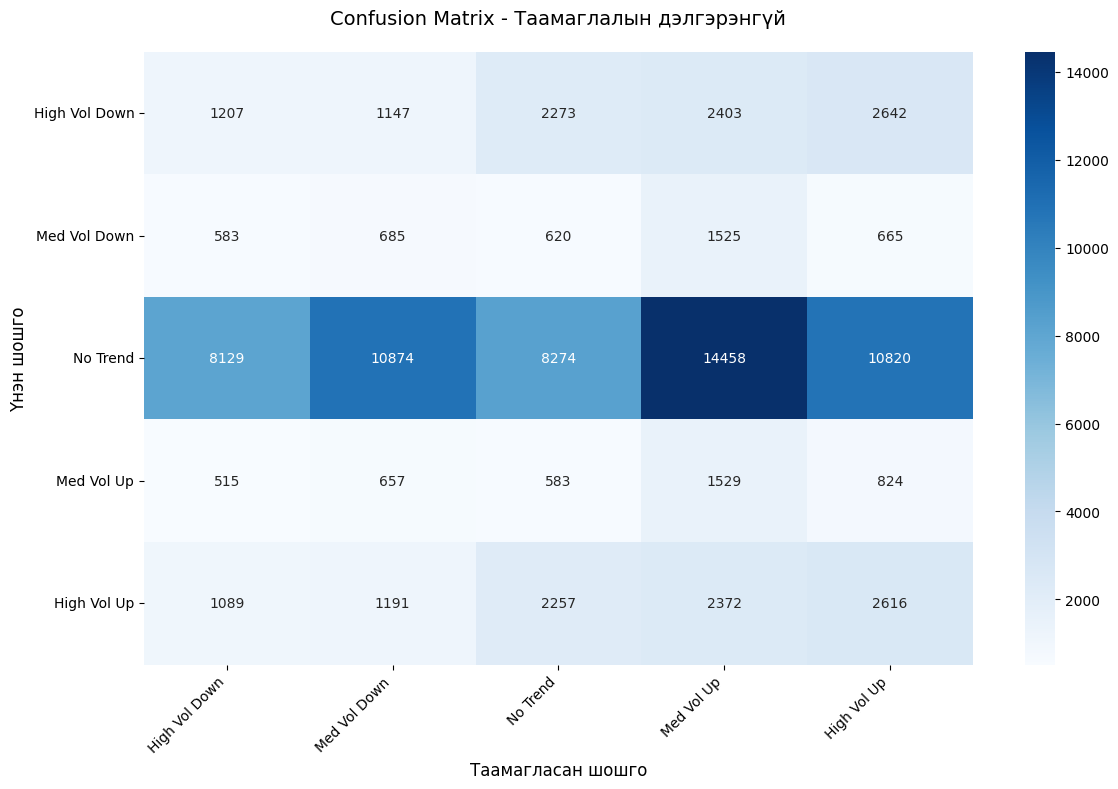


АНГИЛАЛ ТУС БҮРИЙН НАРИЙВЧЛАЛ:
  High Vol Down: 12.48% (9,672 тохиолдол)
  Med Vol Down: 16.80% (4,078 тохиолдол)
  No Trend: 15.74% (52,555 тохиолдол)
  Med Vol Up: 37.22% (4,108 тохиолдол)
  High Vol Up: 27.46% (9,525 тохиолдол)


In [8]:
# Walking Forward Analysis хийх
# train_size болон step_size-ийг датаны хэмжээнээс хамааруулан тохируулна
results_train = walking_forward_analysis(
    df_train, 
    train_size=20000,  # 20,000 мөрөөр сургах
    step_size=5000     # 5,000 мөр таамаглах
)

# Сургалтын үр дүнг үнэлэх
train_accuracy = evaluate_predictions(results_train)

## 8. Test датан дээр Backtest хийх



BACKTEST - TEST ДАТА ДЭЭР ШАЛГАЛТ
Уншиж байна: EUR_USD_test.csv
  Мөрийн тоо: 296,778
  Хугацаа: 2024-12-31 16:00:00+00:00 - 2025-10-17 06:11:00+00:00

Ангилалын хуваарилалт:
  0 - High volatility down: 28,672 (9.7%)
  1 - Medium volatility down: 18,097 (6.1%)
  2 - No trend: 202,518 (68.3%)
  3 - Medium volatility up: 18,927 (6.4%)
  4 - High volatility up: 28,514 (9.6%)

TEST ДАТА БЭЛЭН ✓
  Нийт мөр: 296,728

Walking Forward Analysis эхэлж байна...
  Сургалтын цонх: 10,000 мөр
  Алхамын хэмжээ: 1,000 мөр
  Явц: 5/286 (1.7%)
  Явц: 10/286 (3.5%)
  Явц: 15/286 (5.2%)
  Явц: 20/286 (7.0%)
  Явц: 25/286 (8.7%)
  Явц: 30/286 (10.5%)
  Явц: 35/286 (12.2%)
  Явц: 40/286 (14.0%)
  Явц: 45/286 (15.7%)
  Явц: 50/286 (17.5%)
  Явц: 55/286 (19.2%)


Model is not converging.  Current: -44659.95799321323 is not greater than -44655.24259921067. Delta is -4.7153940025600605


  Явц: 60/286 (21.0%)
  Явц: 65/286 (22.7%)
  Явц: 70/286 (24.5%)
  Явц: 75/286 (26.2%)
  Явц: 80/286 (28.0%)
  Явц: 85/286 (29.7%)
  Явц: 90/286 (31.5%)


Model is not converging.  Current: -41615.81874152877 is not greater than -41611.7851134544. Delta is -4.0336280743649695


  Явц: 95/286 (33.2%)
  Явц: 100/286 (35.0%)
  Явц: 105/286 (36.7%)
  Явц: 110/286 (38.5%)


Model is not converging.  Current: -46030.26790192026 is not greater than -45997.451254680054. Delta is -32.81664724020811


  Явц: 115/286 (40.2%)
  Явц: 120/286 (42.0%)
  Явц: 125/286 (43.7%)
  Явц: 130/286 (45.5%)
  Явц: 135/286 (47.2%)
  Явц: 140/286 (49.0%)
  Явц: 145/286 (50.7%)
  Явц: 150/286 (52.4%)
  Явц: 155/286 (54.2%)
  Явц: 160/286 (55.9%)
  Явц: 165/286 (57.7%)
  Явц: 170/286 (59.4%)
  Явц: 175/286 (61.2%)
  Явц: 180/286 (62.9%)
  Явц: 185/286 (64.7%)
  Явц: 190/286 (66.4%)
  Явц: 195/286 (68.2%)
  Явц: 200/286 (69.9%)
  Явц: 205/286 (71.7%)
  Явц: 210/286 (73.4%)
  Явц: 215/286 (75.2%)
  Явц: 220/286 (76.9%)
  Явц: 225/286 (78.7%)


Model is not converging.  Current: -44480.04114915261 is not greater than -44472.78205726583. Delta is -7.259091886779061


  Явц: 230/286 (80.4%)


Model is not converging.  Current: -36165.7391278281 is not greater than -36156.07624668917. Delta is -9.66288113893097
Model is not converging.  Current: -40027.800098992746 is not greater than -40018.551625643086. Delta is -9.248473349660344


  Явц: 235/286 (82.2%)


Model is not converging.  Current: -42860.70922834795 is not greater than -42859.8653084239. Delta is -0.8439199240528978


  Явц: 240/286 (83.9%)
  Явц: 245/286 (85.7%)
  Явц: 250/286 (87.4%)
  Явц: 255/286 (89.2%)
  Явц: 260/286 (90.9%)
  Явц: 265/286 (92.7%)
  Явц: 270/286 (94.4%)
  Явц: 275/286 (96.2%)
  Явц: 280/286 (97.9%)
  Явц: 285/286 (99.7%)

Walking Forward Analysis дууслаа ✓
  Нийт таамагласан мөр: 286,728

НИЙТ НАРИЙВЧЛАЛ: 19.77%

АНГИЛАЛ ТУС БҮРИЙН ГҮЙЦЭТГЭЛ:
               precision    recall  f1-score   support

High Vol Down       0.09      0.22      0.13     27802
 Med Vol Down       0.07      0.25      0.10     17548
     No Trend       0.66      0.20      0.30    195359
   Med Vol Up       0.06      0.16      0.08     18371
  High Vol Up       0.12      0.18      0.14     27648

     accuracy                           0.20    286728
    macro avg       0.20      0.20      0.15    286728
 weighted avg       0.48      0.20      0.24    286728



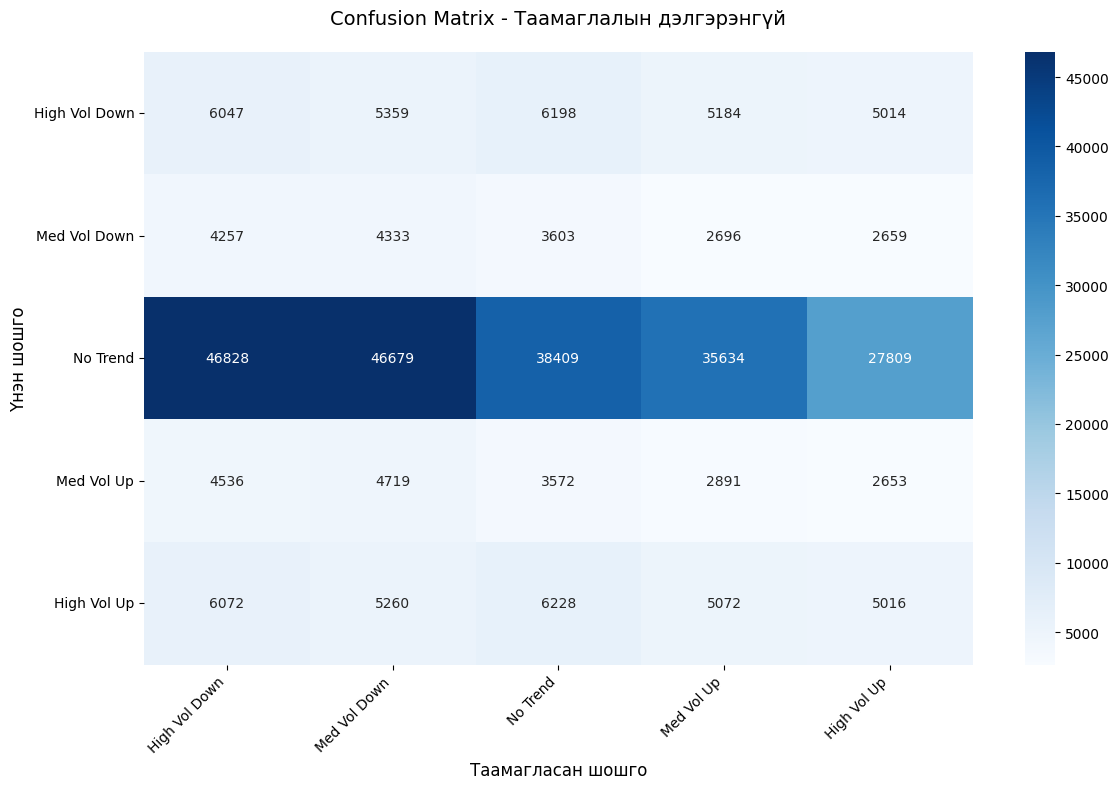


АНГИЛАЛ ТУС БҮРИЙН НАРИЙВЧЛАЛ:
  High Vol Down: 21.75% (27,802 тохиолдол)
  Med Vol Down: 24.69% (17,548 тохиолдол)
  No Trend: 19.66% (195,359 тохиолдол)
  Med Vol Up: 15.74% (18,371 тохиолдол)
  High Vol Up: 18.14% (27,648 тохиолдол)


In [9]:
# Test датанууд
test_folder = 'data/test'
test_files = [
    'EUR_USD_test.csv',
    'GBP_USD_test.csv',
    'USD_CAD_test.csv',
    'USD_CHF_test.csv',
    'USD_JPY_test.csv',
    'XAU_USD_test.csv'
]

print("\n" + "="*60)
print("BACKTEST - TEST ДАТА ДЭЭР ШАЛГАЛТ")
print("="*60)

# EUR_USD test датаг ашиглах
test_file = os.path.join(test_folder, test_files[0])

# Датаг уншиж боловсруулах
df_test = load_forex_data(test_file)
df_test = calculate_features(df_test)
df_test = create_labels(df_test)

print(f"\n{'='*60}")
print(f"TEST ДАТА БЭЛЭН ✓")
print(f"  Нийт мөр: {len(df_test):,}")
print(f"{'='*60}")

# Walking Forward Analysis - Test датан дээр
results_test = walking_forward_analysis(
    df_test,
    train_size=min(10000, len(df_test)//2),  # Test датаны хагасыг сургалтад
    step_size=1000
)

# Test үр дүнг үнэлэх
test_accuracy = evaluate_predictions(results_test)

## 9. Эцсийн модель сургаж хадгалах


In [10]:
print("\n" + "="*60)
print("ЭЦСИЙН МОДЕЛЬ СУРГАЖ БАЙНА...")
print("="*60)

# Бүх сургалтын датаг ашиглан эцсийн модель сургах
X_final, scaler_final = prepare_features_for_hmm(df_train)
final_model = train_hmm_model(X_final, n_components=5, n_iter=100)

print("\nМодель сургагдлаа ✓")

# Модель ба scaler-ийг хадгалах
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

model_path = os.path.join(model_folder, 'hmm_forex_model.pkl')
scaler_path = os.path.join(model_folder, 'hmm_scaler.pkl')

with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler_final, f)

print(f"\nМодель хадгалагдлаа:")
print(f"  {model_path}")
print(f"  {scaler_path}")

# Модель параметрүүд
print(f"\nМодель параметрүүд:")
print(f"  Далд төлөвүүдийн тоо: {final_model.n_components}")
print(f"  Шинж чанарууд: returns, volatility, atr, ma_cross, rsi, volume_change")
print(f"  Covariance type: {final_model.covariance_type}")


ЭЦСИЙН МОДЕЛЬ СУРГАЖ БАЙНА...

Модель сургагдлаа ✓

Модель хадгалагдлаа:
  models\hmm_forex_model.pkl
  models\hmm_scaler.pkl

Модель параметрүүд:
  Далд төлөвүүдийн тоо: 5
  Шинж чанарууд: returns, volatility, atr, ma_cross, rsi, volume_change
  Covariance type: full


## 10. Эцсийн дүгнэлт


In [11]:
print("\n" + "="*60)
print("ЭЦСИЙН ДҮН")
print("="*60)

print(f"\n📊 ГҮЙЦЭТГЭЛ:")
print(f"  Сургалтын нарийвчлал: {train_accuracy*100:.2f}%")
print(f"  Test нарийвчлал: {test_accuracy*100:.2f}%")

print(f"\n🎯 АНГИЛАЛУУД:")
print(f"  0 - High volatility down")
print(f"  1 - Medium volatility down")
print(f"  2 - No trend")
print(f"  3 - Medium volatility up")
print(f"  4 - High volatility up")

print(f"\n💾 ХАДГАЛСАН ФАЙЛУУД:")
print(f"  - models/hmm_forex_model.pkl (HMM модель)")
print(f"  - models/hmm_scaler.pkl (Feature scaler)")

print(f"\n📱 REACT NATIVE АППЛИКЕЙШН ХӨГЖҮҮЛЭХЭД:")
print(f"  1. Python backend API үүсгэх (Flask/FastAPI)")
print(f"  2. Модель ачаалж, шинэ датан дээр таамаглал хийх endpoint үүсгэх")
print(f"  3. React Native frontend-оос API дуудах")
print(f"  4. Үр дүнг график болон текстээр харуулах")

print(f"\n✅ МАШИН СУРГАЛТЫН ПРОЦЕСС АМЖИЛТТАЙ ДУУСЛАА!")
print("="*60)


ЭЦСИЙН ДҮН

📊 ГҮЙЦЭТГЭЛ:
  Сургалтын нарийвчлал: 17.90%
  Test нарийвчлал: 19.77%

🎯 АНГИЛАЛУУД:
  0 - High volatility down
  1 - Medium volatility down
  2 - No trend
  3 - Medium volatility up
  4 - High volatility up

💾 ХАДГАЛСАН ФАЙЛУУД:
  - models/hmm_forex_model.pkl (HMM модель)
  - models/hmm_scaler.pkl (Feature scaler)

📱 REACT NATIVE АППЛИКЕЙШН ХӨГЖҮҮЛЭХЭД:
  1. Python backend API үүсгэх (Flask/FastAPI)
  2. Модель ачаалж, шинэ датан дээр таамаглал хийх endpoint үүсгэх
  3. React Native frontend-оос API дуудах
  4. Үр дүнг график болон текстээр харуулах

✅ МАШИН СУРГАЛТЫН ПРОЦЕСС АМЖИЛТТАЙ ДУУСЛАА!


## Нэмэлт: Модель ашиглах жишээ


In [12]:
# Модель ачаалах жишээ
def load_model_and_predict(data_file):
    """
    Хадгалагдсан модель ашиглан шинэ дата дээр таамаглал хийх
    """
    # Модель ачаалах
    with open('models/hmm_forex_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open('models/hmm_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    # Дата уншиж боловсруулах
    df = load_forex_data(data_file)
    df = calculate_features(df)
    
    # Шинж чанаруудыг бэлдэх
    feature_columns = ['returns', 'volatility', 'atr', 'ma_cross', 'rsi', 'volume_change']
    X = scaler.transform(df[feature_columns].values)
    
    # Таамаглал хийх
    predictions = model.predict(X)
    
    # Ангилалын нэрс
    label_names = {
        0: 'High volatility down',
        1: 'Medium volatility down',
        2: 'No trend',
        3: 'Medium volatility up',
        4: 'High volatility up'
    }
    
    # Үр дүн
    df['predicted_trend'] = predictions
    df['trend_name'] = df['predicted_trend'].map(label_names)
    
    return df

print("\nМодель ашиглах функц бэлэн ✓")
print("Жишээ: load_model_and_predict('test_data.csv')")


Модель ашиглах функц бэлэн ✓
Жишээ: load_model_and_predict('test_data.csv')
